# Movie Recommendation model

There can be three different types of recommendation systems:
1. Demographic filtering, where the recommendations are the same for every user despite their interests. The more popular and more critically acclaimed movies are highly recommended.
2. Content-based filtering, where movie metadata is taken into consideration. This will make the recommendation a bit more personalised since similar movies should be suggested to the user.
3. Collaboration-based filtering, where users with similar interests are grouped and movies are recommended to them

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity
from ast import literal_eval

## Dataset

In [2]:
metadata_df = pd. read_csv('../datasets/movies_dataset/movies_metadata.csv')
metadata_df['genres'] = metadata_df['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
print(f'Samples: {metadata_df.shape[0]} \nFeatures: {metadata_df.shape[1]}')
metadata_df.head()

/tmp/ipykernel_257350/1629353149.py:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata_df = pd. read_csv('../datasets/movies_dataset/movies_metadata.csv')


Samples: 45466 
Features: 24


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[Animation, Comedy, Family]",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[Adventure, Fantasy, Family]",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[Romance, Comedy]",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[Comedy, Drama, Romance]",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,[Comedy],NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
# Missing values
metadata_df.isnull().sum()

adult                        0
belongs_to_collection    40972
budget                       0
genres                       0
homepage                 37684
id                           0
imdb_id                     17
original_language           11
original_title               0
overview                   954
popularity                   5
poster_path                386
production_companies         3
production_countries         3
release_date                87
revenue                      6
runtime                    263
spoken_languages             6
status                      87
tagline                  25054
title                        6
video                        6
vote_average                 6
vote_count                   6
dtype: int64

## Demographic filtering
This is going to be the simplest and most generic model, since it only requires data sorting based on their rating and popularity.
IMDB's weighted rating formula is used to sort the movies:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the movie
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the movie
* *C* is the mean vote across the whole report

*m* will be defined using the **90th** percentile. This can be adjusted to cut-off or allow more movies in our set.

In [4]:
def weighted_rating(movie_df, C, m):
    v = movie_df['vote_count']
    R = movie_df['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [5]:
def build_chart(df, genre=None, percentile=0.9):
    if genre:
        df = df[df['genres'].apply(lambda x: genre in x)]
    C = df["vote_average"].astype('int').mean()
    m = df["vote_count"].astype('int').quantile(percentile)
    print(f'C: {C}\nm: {m}')

    popular_movies_df = cleaned_df.copy().loc[cleaned_df["vote_count"] >= m][['title', 'year', 'vote_count', 'vote_average', 'popularity', 'genres']].reset_index(drop=True)
    popular_movies_df['weighted_rating'] = popular_movies_df.apply(weighted_rating, args=(C, m), axis=1)
    popular_movies_df = popular_movies_df.sort_values('weighted_rating', ascending=False)

    return popular_movies_df

In [6]:
# Drop rows with NaN or null values only in columns 'vote_count' and 'vote_average'
cleaned_df = metadata_df.dropna(subset=['vote_count', 'vote_average'])
cleaned_df['year'] = pd.to_datetime(cleaned_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)

popular_movies_df = build_chart(cleaned_df)
popular_movies_df.head(10)

C: 5.244896612406511
m: 160.0


/tmp/ipykernel_257350/621783621.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['year'] = pd.to_datetime(cleaned_df['release_date'], errors='coerce').apply(lambda x: str(x).split('-')[0] if x != np.nan else np.nan)


,title,year,vote_count,vote_average,popularity,genres,weighted_rating
101,The Shawshank Redemption,1994,8358.0,8.5,51.645403,"[Drama, Crime]",8.438857
230,The Godfather,1972,6024.0,8.5,41.109264,"[Drama, Crime]",8.415780
1966,Dilwale Dulhania Le Jayenge,1995,661.0,9.1,34.457024,"[Comedy, Drama, Romance]",8.348701
2398,The Dark Knight,2008,12269.0,8.3,123.167259,"[Drama, Action, Crime, Thriller]",8.260671
916,Fight Club,1999,9678.0,8.3,63.869599,[Drama],8.250313
91,Pulp Fiction,1994,8670.0,8.3,140.950236,"[Thriller, Crime]",8.244641
168,Schindler's List,1993,4436.0,8.3,41.725123,"[Drama, History, War]",8.193643
3738,Whiplash,2014,4376.0,8.3,64.29999,[Drama],8.192236
1437,Spirited Away,2001,3968.0,8.3,41.048867,"[Fantasy, Adventure, Animation, Family]",8.181585
726,Life Is Beautiful,1997,3643.0,8.3,39.39497,"[Comedy, Drama]",8.171466


In [7]:
def plot_chart(df, numOfDisplayedMovies, genre=None):
    df['popularity'] = df['popularity'].astype(float)
    popularity = df.sort_values("popularity", ascending=False)
    
    plt.figure(figsize=(12, 6))
    bars = plt.barh(df["title"].head(numOfDisplayedMovies), df["popularity"].head(numOfDisplayedMovies), align="center", color="skyblue")
    
    # Add value labels to the end of each bar
    for bar, rating in zip(bars, df["weighted_rating"].head(numOfDisplayedMovies)):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2, f'{rating:.2f}', va='center')
    
    plt.gca().invert_yaxis()
    genreStr = "Genre: "
    if genre:
        genreStr += genre
    else:
        genreStr += "any"
    plt.title("Top " + str(numOfDisplayedMovies) + " movies based on weighted rating. " + genreStr)
    plt.xlabel("Popularity")
    plt.ylabel("Movie name")
    plt.show()

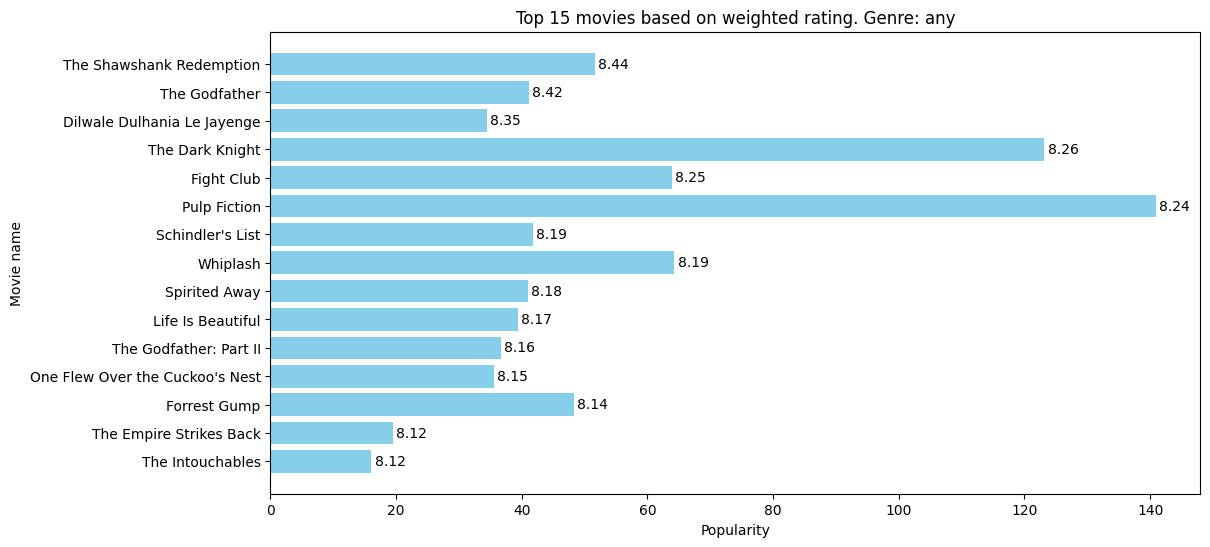

In [8]:
plot_chart(popular_movies_df, 15)

Now we can repeat the process for specific movie genres:

C: 5.474344091014627
m: 121.0


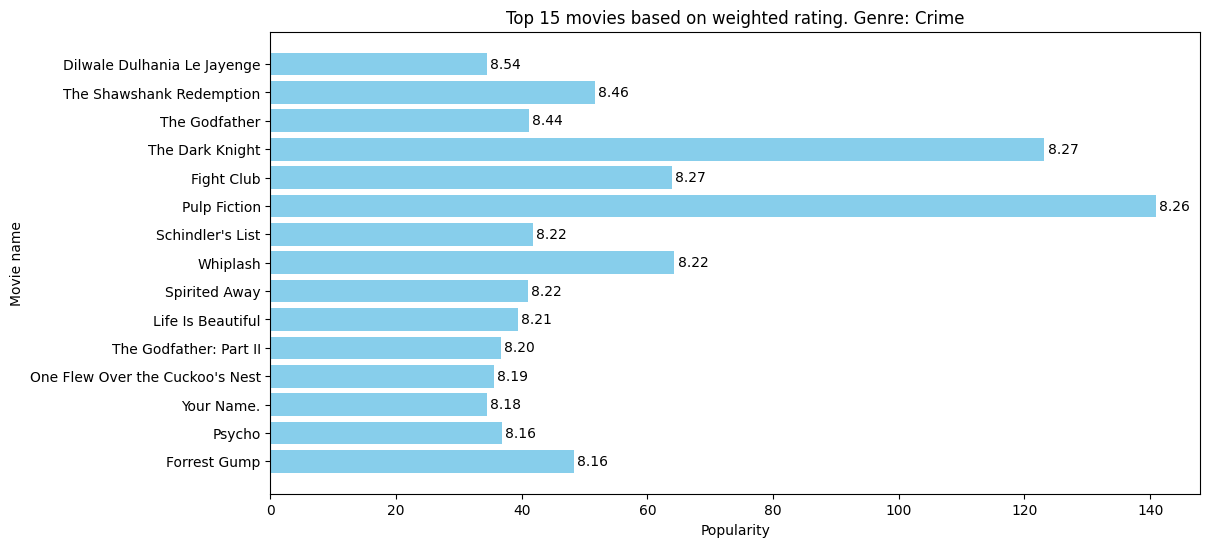

In [9]:
popular_crime_movies_df = build_chart(cleaned_df, genre='Crime', percentile=0.8)
popular_crime_movies_df.head(10)
plot_chart(popular_crime_movies_df, 15, 'Crime')

It is obvious that the recommender presented above, uses the same parameters and provides the same recommendations to everybody.  

## Content-based Filtering
To make it more personalised, a new model will be built, that takes into consideration the similarities between movies. This enables suggestions that are similar to a movie that the user liked previously. 
Some of the features that one can take into consideration to calculate the similarity could be:
- cast
- keywords
- genre
- overview
- taglines

In [10]:
# Drop rows with incorrect data
# Convert the column to numeric, coercing non-integer values to NaN
metadata_df['id'] = pd.to_numeric(metadata_df['id'], errors='coerce')

# Drop rows with NaN values in the specified column
metadata_df = metadata_df.dropna(subset=['id'])

metadata_df['id'] = metadata_df['id'].astype('int')

In [11]:
# Keep only the entries that appear in links_small.csv
links_small = pd.read_csv('../datasets/movies_dataset/links_small.csv')
links_small = links_small[links_small['tmdbId'].notnull()]['tmdbId'].astype('int')

small_metadata_df = metadata_df[metadata_df['id'].isin(links_small)]
small_metadata_df.shape

(9099, 24)

### Overview and tagline

In [12]:
# Replace NaNs with empty strings
small_metadata_df['tagline'] = small_metadata_df['tagline'].fillna('')
small_metadata_df['overview'] = small_metadata_df['overview'].fillna('')

# Create a new cell containing both the information
small_metadata_df['description'] = small_metadata_df['overview'] + small_metadata_df['tagline']

# Define the model
tfidf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
tfidf_matrix = tfidf.fit_transform(small_metadata_df['description'])
print(f"Vectorizer shape : {tfidf_matrix.shape}")



/tmp/ipykernel_257350/4217843720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['tagline'] = small_metadata_df['tagline'].fillna('')
/tmp/ipykernel_257350/4217843720.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['overview'] = small_metadata_df['overview'].fillna('')
/tmp/ipykernel_257350/4217843720.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

Vectorizer shape : (9099, 268124)


Since we have used the TF-IDF Vectorizer, the dot product of TF-IDF vectors is directly proportional to their cosine similarity. Therefore, using the dot product of TF-IDF vectors directly gives us the cosine similarity score without the need for additional normalization.

sklearn's `linear_kernel` function efficiently computes the dot product between TF-IDF vectors, making it faster than explicitly computing `cosine_similarities`. Therefore, when using TF-IDF vectors for similarity calculations, `linear_kernel` is preferred for its speed and efficiency.

In [13]:
# Compute cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [14]:
def get_recommendations(title, dataset, maxNumOfSimilar=10):
    titles = dataset['title']
    indices = pd.Series(dataset.index, index=dataset['title'])
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:maxNumOfSimilar + 1]
    movies_indices = [ind[0] for ind in sim_scores]
    movies = dataset["title"].iloc[movies_indices]
    return movies

In [15]:
get_recommendations('The Godfather', small_metadata_df.reset_index(), 20).head(15)

973      The Godfather: Part II
8387                 The Family
3509                       Made
4196         Johnny Dangerously
29               Shanghai Triad
5667                       Fury
2412             American Movie
1582    The Godfather: Part III
4221                    8 Women
2159              Summer of Sam
618                     Thinner
3609              Harlem Nights
8816              Run All Night
3288          Jaws: The Revenge
2192           The Color Purple
Name: title, dtype: object

### Metadata recommender

In [16]:
credits = pd.read_csv('../datasets/movies_dataset/credits.csv')
credits.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [17]:
keywords = pd.read_csv('../datasets/movies_dataset/keywords.csv')
keywords.head(5)

,id,keywords
0,862,"[{'id': 931, 'name': 'jealousy'}, {'id': 4290,..."
1,8844,"[{'id': 10090, 'name': 'board game'}, {'id': 1..."
2,15602,"[{'id': 1495, 'name': 'fishing'}, {'id': 12392..."
3,31357,"[{'id': 818, 'name': 'based on novel'}, {'id':..."
4,11862,"[{'id': 1009, 'name': 'baby'}, {'id': 1599, 'n..."


Update the dataset by merging the credits and keywords dataframes to the initial.

In [18]:
keywords['id'] = keywords['id'].astype('int')
credits['id'] = credits['id'].astype('int')
metadata_df['id'] = metadata_df['id'].astype('int')
metadata_df = metadata_df.merge(credits, on='id')
metadata_df = metadata_df.merge(keywords, on='id')
metadata_df.shape

(46628, 27)

In [19]:
small_metadata_df = metadata_df[metadata_df['id'].isin(links_small)]
small_metadata_df.shape

(9219, 27)

After merging crew, cast and keywords on the original dataframe we will use:
 - **director**  from 'crew', since usually it's the main feature from the list that affects audience's preferences
 - Top **N** actors from 'cast', since using the whole cast is adding unnecessary complexity

In [20]:
small_metadata_df['cast'] = small_metadata_df['cast'].apply(literal_eval)
small_metadata_df['crew'] = small_metadata_df['crew'].apply(literal_eval)
small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(literal_eval)
small_metadata_df['cast_size'] = small_metadata_df['cast'].apply(lambda x: len(x))
small_metadata_df['crew_size'] = small_metadata_df['crew'].apply(lambda x: len(x))

/tmp/ipykernel_257350/3288429176.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['cast'] = small_metadata_df['cast'].apply(literal_eval)
/tmp/ipykernel_257350/3288429176.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['crew'] = small_metadata_df['crew'].apply(literal_eval)
/tmp/ipykernel_257350/3288429176.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [21]:
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

small_metadata_df['director'] = small_metadata_df['crew'].apply(get_director)

/tmp/ipykernel_257350/4282292404.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['director'] = small_metadata_df['crew'].apply(get_director)


In [22]:
# Define number of actors used 
N = 3
small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: x[:N] if len(x) >=N else x)
small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

/tmp/ipykernel_257350/884029961.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])
/tmp/ipykernel_257350/884029961.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: x[:N] if len(x) >=N else x)
/tmp/ipykernel_257350/884029961.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Da

Following the same approach as above, we will use a vectorizer on a dataset consisting of the **genre**, **director**, **top actors** and **keywords**. Instead of `TfidfVectorizer`, `CountVectorizer` will be used, for computational efficiency, since we aim to count the words' occurencies and not assess their importance as well.

Furthermore some data preprocessing needs to take place:
 - replace whitespace from full names with '_' to avoid confusing people with the same first name and convert them to lowercase
 - keywords' lemmatization

Also we will assign extra weight to the director, by repeating its occurance on the dataset, so that the recommender will provide multiple movies of them.

#### Preprocessing

In [23]:
# Convert names
small_metadata_df.loc[:, 'cast'] = small_metadata_df['cast'].apply(lambda x: [str.lower(i.replace(" ", "_")) for i in x])
small_metadata_df['director'] = small_metadata_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "_")))
# Director extra weight
small_metadata_df['director'] = small_metadata_df['director'].apply(lambda x: [x,x, x])

/tmp/ipykernel_257350/1212987834.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['director'] = small_metadata_df['director'].astype('str').apply(lambda x: str.lower(x.replace(" ", "_")))
/tmp/ipykernel_257350/1212987834.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['director'] = small_metadata_df['director'].apply(lambda x: [x,x, x])


In [24]:
s = small_metadata_df.apply(lambda x: pd.Series(x['keywords']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'keyword'
s = s.value_counts()
s.head()

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
Name: count, dtype: int64

In [25]:
# Calculate the quantile threshold for the top a% keywords
quantile = 0.1  # Specify the percentage of top keywords to keep
threshold = s.quantile(1 - quantile)

# Filter the keywords based on the threshold
top_keywords = s[s >= threshold]

print(top_keywords)

keyword
independent film        610
woman director          550
murder                  399
duringcreditsstinger    327
based on novel          318
                       ... 
battlefield              10
nazism                   10
good and bad             10
director                 10
female corpse            10
Name: count, Length: 1369, dtype: int64


In [26]:
def findTopKeywords(x):
    words = []
    for i in x:
        if i in s:
            words.append(i)
    return words

small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(findTopKeywords)


/tmp/ipykernel_257350/2843150605.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(findTopKeywords)


In [27]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

def lemmatize(text_list):
    # Initialize WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # Convert each word in the list to lowercase and lemmatize it
    lemmatized_words = [lemmatizer.lemmatize(word.lower()) for word in text_list]
    
    # Replace whitespace in lemmatized words with '_'
    lemmatized_words = [word.replace(' ', '_') for word in lemmatized_words]
    
    return lemmatized_words

small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(lambda x: lemmatize(x))

/tmp/ipykernel_257350/2691874713.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(lambda x: lemmatize(x))


In [28]:
# Print lemmatization result sample
print(small_metadata_df.loc[:5]['keywords'])

0    [jealousy, toy, boy, friendship, friend, rival...
1    [board_game, disappearance, based_on_children'...
2    [fishing, best_friend, duringcreditsstinger, o...
3    [based_on_novel, interracial_relationship, sin...
4    [baby, midlife_crisis, confidence, aging, daug...
5    [robbery, detective, bank, obsession, chase, s...
Name: keywords, dtype: object


In [29]:
# Create a new column containing all the features (input) in one string

# Convert lists to strings before concatenating
small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(lambda x: ' '.join(x))
small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: ' '.join(x))
small_metadata_df['director'] = small_metadata_df['director'].apply(lambda x: ' '.join(x))
small_metadata_df['genres'] = small_metadata_df['genres'].apply(lambda x: ' '.join(x))

# Concatenate the columns
small_metadata_df['soup'] = small_metadata_df['keywords'] + ' ' + small_metadata_df['cast'] + ' ' + small_metadata_df['director'] + ' ' + small_metadata_df['genres']

# Display the updated DataFrame
print(small_metadata_df['soup'])

0        jealousy toy boy friendship friend rivalry boy...
1        board_game disappearance based_on_children's_b...
2        fishing best_friend duringcreditsstinger old_m...
3        based_on_novel interracial_relationship single...
4        baby midlife_crisis confidence aging daughter ...
                               ...                        
45985    sequel pokémon celebi veronica_taylor rachael_...
46424    female_nudity dark_comedy family_vacation aval...
46425    female_nudity dark_comedy family_vacation aval...
46426    female_nudity dark_comedy family_vacation aval...
46427    female_nudity dark_comedy family_vacation aval...
Name: soup, Length: 9219, dtype: object


/tmp/ipykernel_257350/2872133453.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['keywords'] = small_metadata_df['keywords'].apply(lambda x: ' '.join(x))
/tmp/ipykernel_257350/2872133453.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  small_metadata_df['cast'] = small_metadata_df['cast'].apply(lambda x: ' '.join(x))
/tmp/ipykernel_257350/2872133453.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

#### Model

In [30]:
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0.0, stop_words='english')
count_matrix = count.fit_transform(small_metadata_df['soup'])

# Compute cosine similarity
cosine_sim = cosine_similarity(count_matrix, count_matrix)

#### Results

In [31]:
small_metadata_df = small_metadata_df.reset_index()
titles = small_metadata_df['title']
indices = pd.Series(small_metadata_df.index, index=small_metadata_df['title'])

get_recommendations('The Godfather', small_metadata_df, 20).head(15)

3600    Tucker: The Man and His Dream
982            The Godfather: Part II
1338                    The Rainmaker
3689                  The Cotton Club
4490               One from the Heart
3292                 Gardens of Stone
1594          The Godfather: Part III
2990                 The Conversation
1984            Peggy Sue Got Married
1683                    The Outsiders
5831                      Rumble Fish
638                              Jack
969                    Apocalypse Now
1088                          Dracula
4128                      The Gambler
Name: title, dtype: object

In [32]:
get_recommendations('The Dark Knight', small_metadata_df, 20).head(15)

7991                 The Dark Knight Rises
6186                         Batman Begins
6587                          The Prestige
2077                             Following
4125                              Insomnia
7608                             Inception
3373                               Memento
8573                          Interstellar
7619            Batman: Under the Red Hood
1122                        Batman Returns
8899               Kidnapping Mr. Heineken
5907                              Thursday
1252                        Batman & Robin
9004    Batman v Superman: Dawn of Justice
4005                  The Long Good Friday
Name: title, dtype: object

## Next step
As a result, our recommender suggests movies from the same director since we've assigned extra importance to this feature. As a next step one could create a **Collaboration-based** model that uses the `ratings_small.csv` to take into consideration each user's rating for different movies. This will result into a model that suggests movies to each user based also on how they, and other users with similar taste, rated watched movies.